In [1]:
from tqdm import tqdm
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import encodermap as em

/home/leonf/git/encoder_map_private/encodermap/loading/features.py:36: UserWarning: Features need Unittests
  warnings.warn("Features need Unittests")


# EncoderMap embedding for the closeness centralities of full-lenght FAT10

## Loading closeness centralities 
Closeness centralities were calculated in [1_Calculating_Closeness_Centralities_full_length_FAT10.ipynb](./1_Calculating_Closeness_Centralities_full_length_FAT10.ipynb)

Shape: (n_frames, n_residues) --> (300150,165) 

In [2]:
closeness = np.load("./Closeness_Centralities_full_length_FAT10.npy")
closeness = closeness/np.max(closeness) #normalizing to have max = 1 in case this was not done upon calculation. This can aid in obtaining better EncoderMap results. 

## Setting parameters for EncoderMap
Please refer to the original publications of EncoderMap ([Paper I](https://pubs.acs.org/doi/full/10.1021/acs.jctc.8b00975) and [Paper II](https://pubs.acs.org/doi/10.1021/acs.jcim.9b00675)) and the [python package documentation](https://github.com/AG-Peter/encodermap) for details on using EncoderMap and parameter selection. 


(<AxesSubplot:title={'center':'high-d'}, xlabel='distance'>,
 <AxesSubplot:label='55ca058e-366c-437c-922b-e2023400cb3d'>,
 <AxesSubplot:title={'center':'low-d'}, xlabel='distance'>)

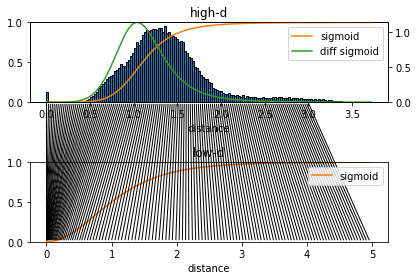

In [3]:
%matplotlib inline
parameters = em.Parameters()
parameters.main_path = em.misc.run_path("encodermap_runs_FAT10")
parameters.n_steps = 25000
parameters.dist_sig_parameters = (1.1 ,6 ,6 , 1, 2, 6)
parameters.learning_rate = 0.00001 
parameters.l2_reg_constant = 0.00001
parameters.periodicity = float('inf')
# if your data set is large you should not try to calculate 
# the pairwise distance histogram with the complete data.
em.plot.distance_histogram(closeness[::1000],  # e.g. use high_d_data[::100] to use every 100th point
                           parameters.periodicity, 
                           parameters.dist_sig_parameters)

## Running EncoderMap

In [4]:
e_map = em.EncoderMap(parameters, closeness)
e_map.train()

low_d_projection = e_map.encode(closeness)

Output files are saved to encodermap_runs_FAT10/run0 as defined in 'main_path' in the parameters.


100%|██████████| 25000/25000 [02:27<00:00, 169.83it/s, Loss after step 25000=5.59]


## Plotting the resulting low-dimensional embedding, colored by population density

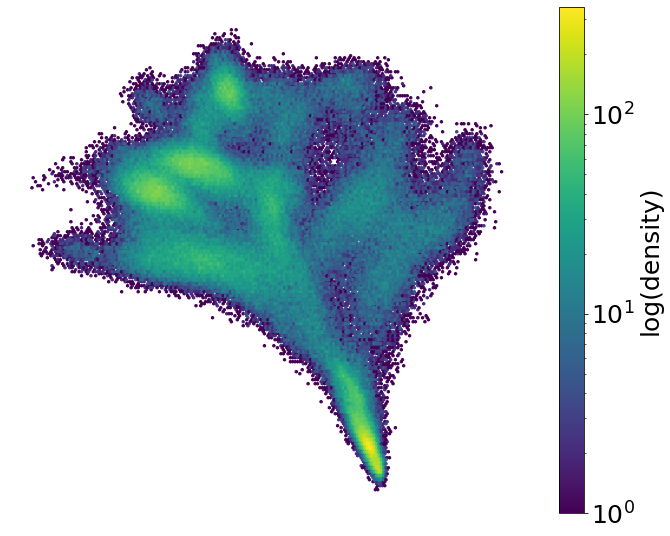

In [5]:
%matplotlib inline
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize = (10,8),tight_layout = True)
hex_map = ax.hexbin(low_d_projection[:, 0], 
                    low_d_projection[:, 1],
                    cmap = 'viridis', 
                    bins = 'log', 
                    mincnt = 1, 
                    gridsize = 200)
ax.set_axis_off()
cb = plt.colorbar(hex_map, label = "log(density)")
cb.set_alpha(1)
cb.draw_all()

## Note: EncoderMap is non-deterministic.
This means the resulting embeddings can deviate between runs. 
The embeddings may appear rotated or flipped or differ slightly in other details. This can lead to differing results when using HDBSCAN, such as deviations in cluster numbering. To ensure consistency with the analyses in the paper, we provide the [coordinates of the EncoderMap that was used in the paper](./EncoderMap_low_d_coordinates_full_length_FAT10.npy) and proceed in the analyses with those. 